In [1]:
!pip install -q swig
!pip3 install gym[all]
!pip3 install gym[accept-rom-license]
!pip install gym pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.2 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373077 sha256=63a29c3862cf3be970825b028640bfffa63f707f7deb8129a001

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [3]:
from pyvirtualdisplay import Display
!apt-get install xvfb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 6 not upgraded.
Need to get 7,814 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archive

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video', episode_trigger = lambda episode_number: True)
  return env

In [16]:
import random
import math
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import json
import os
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import gym
from gym.wrappers import  AtariPreprocessing, FrameStack

use_cuda = torch.cuda.is_available()


class DQN(nn.Module):
        def __init__(self, channels, num_actions):
            super(DQN, self).__init__()
            self.conv1 = nn.Conv2d(channels, 32, kernel_size=8, stride=4)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
            self.fc = nn.Linear(64*7*7, 512)  # Adjusted input size
            self.head = nn.Linear(512, num_actions)
            self.relu = nn.ReLU()
            self.lrelu = nn.LeakyReLU(0.01)

        def forward(self, x):
            x = x.float()
            x = self.relu(self.conv1(x))
            x = self.relu(self.conv2(x))
            x = self.relu(self.conv3(x))
            # Flatten the tensor before the fully connected layer
            x = x.view(x.size(0), -1)
            x = self.lrelu(self.fc(x))
            q = self.head(x)
            return q




class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.position = 0
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        if len(self.memory) < self.buffer_size:
            self.memory.append(None)
        self.memory[self.position] = e
        self.position = (self.position + 1) % self.buffer_size
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.cat([e.state for e in experiences if e is not None]).float().cuda()
        next_states = torch.cat([e.next_state for e in experiences if e is not None]).float().cuda()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().cuda()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().cuda()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().cuda()
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)


class AgentDQN():
    def __init__(self, env):
        self.env = env
        self.input_channels = 4
        self.num_actions = self.env.action_space.n
        print('Using Deep Q network Network')
        self.online_net = DQN(self.input_channels, self.num_actions)
        self.online_net = self.online_net.cuda() if use_cuda else self.online_net
        self.target_net = DQN(self.input_channels, self.num_actions)
        self.target_net = self.target_net.cuda() if use_cuda else self.target_net
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.GAMMA = 0.99
        # training hyperparameters
        self.train_freq = 4 # frequency to train the online network
        self.num_timesteps = 1000000# total training steps
        self.learning_start = 10000 # before we start to update our network, we wait a few steps first to fill the replay.
        self.batch_size = 32
        self.display_freq = 25 # frequency to display training progress
        self.target_update_freq = 1000 # frequency to update target network
        # optimizer
        self.optimizer = optim.RMSprop(self.online_net.parameters(), lr=1e-4)
        self.steps = 0 # num. of passed steps. this may be useful in controlling exploration
        self.eps_min = 0.025
        self.eps_max = 1.0
        self.eps_step = 60000
        self.plot = {'steps':[], 'reward':[]}
        # Initialize your replay buffer
        self.memory = ReplayBuffer(100000, self.batch_size)
        self.test_actions = []

    def save(self, save_path):
        print('save model to', save_path)
        model = {'online': self.online_net.state_dict(), 'target': self.target_net.state_dict()}
        torch.save(model, save_path)

    def load(self, load_path):
        print('Load model from', load_path)
        if use_cuda:
            self.online_net.load_state_dict(torch.load(load_path)['online'])
        else:
            self.online_net.load_state_dict(torch.load(load_path, map_location=lambda storage, loc: storage)['online'])

    def epsilon(self, step):
        if step > self.eps_step:
            return 0
        else:
            return self.eps_min + (self.eps_max - self.eps_min) * ((self.eps_step - step) / self.eps_step)

    def make_action(self, state, test=False):
        if test:
            state = torch.from_numpy(state).unsqueeze(0)
            state = state.cuda() if use_cuda else state
            with torch.no_grad():
                action = self.online_net(state).max(1)[1].item()
        else:
            if random.random() > self.epsilon(self.steps):
                with torch.no_grad():
                    # print(type(state))
                    action = self.online_net(state).max(1)[1].item()
            else:
                action = random.randrange(self.num_actions)

        return action

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        experiences = self.memory.sample()
        batch_state, batch_action, batch_reward, batch_next, batch_done, = experiences
        next_q_values =  self.target_net(batch_next).detach()
        next_q_values = next_q_values.max(1)[0].unsqueeze(1)
        batch_reward = batch_reward.clamp(-1.1)
        current_q = self.online_net(batch_state).gather(1, batch_action)
        next_q = batch_reward + (1 - batch_done) * self.GAMMA * next_q_values
        loss = F.mse_loss(current_q, next_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self):
        best_reward = 0
        episodes_done_num = 1 # passed episodes
        total_reward = [] # compute average reward
        total_loss = []
        while(True):
            state = np.array(self.env.reset())
            # State: (84,84,4) --> (1,4,84,84)
            state = torch.from_numpy(state).unsqueeze(0)
            state = state.cuda() if use_cuda else state
            done = False
            episodes_reward = []
            episodes_loss = []
            while(not done):
                action = self.make_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array(next_state)
                episodes_reward.append(reward)
                total_reward.append(reward)
                next_state = torch.from_numpy(next_state).unsqueeze(0)
                next_state = next_state.cuda() if use_cuda else next_state
                self.memory.add(state, action, reward, next_state, done)
                state = next_state
                if self.steps > self.learning_start and self.steps % self.train_freq == 0:
                    loss = self.update()
                    episodes_loss.append(loss)
                    total_loss.append(loss)
                if self.steps > self.learning_start and self.steps % self.target_update_freq == 0:
                    self.target_net.load_state_dict(self.online_net.state_dict())
                self.steps += 1

            avg_ep_loss = sum(episodes_loss)/len(episodes_loss) if len(episodes_loss) > 0 else 0

            print('Episode: %d | Steps: %d/%d | Avg reward: %f | Loss: %f'%
                 (episodes_done_num, self.steps, self.num_timesteps,
                  sum(episodes_reward), avg_ep_loss),end='\r')

            self.plot['steps'].append(episodes_done_num)
            self.plot['reward'].append(sum(episodes_reward))

            if episodes_done_num % self.display_freq == 0:

                avg_reward = sum(total_reward) / self.display_freq
                avg_loss = sum(total_loss) / len(total_loss) if len(total_loss) > 0 else 0

                if self.steps < self.eps_step:
                    phase = "Exploring phase"
                else:
                    phase = "Learning phase"

                print('%s | Episode: %d | Steps: %d/%d | epsilon: %f | Avg reward: %f | Loss: %f'%
                        (phase, episodes_done_num, self.steps, self.num_timesteps,
                            self.epsilon(self.steps), avg_reward, avg_loss))
                total_reward = []
                total_loss = []
            episodes_done_num += 1
            if self.steps > self.num_timesteps:
                # if not os.path.exists('models/DQN'):
                #     os.makedirs('models/DQN')
                # save_path = os.path.join('./models/DQN', f'save_{game}_{self.GAMMA}.cpt')
                # self.save(save_path)
                ##############test#############
                state = np.array(self.env.reset(seed=30))
                # State: (84,84,4) --> (1,4,84,84)
                state = torch.from_numpy(state).unsqueeze(0)
                state = state.cuda() if use_cuda else state
                done = False
                while(not done):
                      action = self.make_action(state)
                      next_state, reward, done, _ = self.env.step(action)
                      next_state = np.array(next_state)
                      self.test_actions.append(action)
                      next_state = torch.from_numpy(next_state).unsqueeze(0)
                      next_state = next_state.cuda() if use_cuda else next_state
                      state = next_state
                #######test###########
                plt.plot(self.plot['steps'], self.plot['reward'])
                plt.xlabel('Episodes')
                plt.ylabel('Rewards')
                plt.title('DQN')
                if not os.path.exists('Plots/DQN'):
                    os.makedirs('Plots/DQN')
                plt.savefig(f'Plots/DQN/{game}_{self.GAMMA}.png')
                break  

Using Deep Q network Network
Exploring phase | Episode: 25 | Steps: 23181/1000000 | epsilon: 0.623309 | Avg reward: -20.240000 | Loss: 0.797396
Exploring phase | Episode: 50 | Steps: 46164/1000000 | epsilon: 0.249835 | Avg reward: -20.200000 | Loss: 0.018216
Learning phase | Episode: 75 | Steps: 68390/1000000 | epsilon: 0.000000 | Avg reward: -20.600000 | Loss: 0.014844
Learning phase | Episode: 100 | Steps: 93513/1000000 | epsilon: 0.000000 | Avg reward: -19.880000 | Loss: 0.009804
Learning phase | Episode: 125 | Steps: 124863/1000000 | epsilon: 0.000000 | Avg reward: -18.880000 | Loss: 0.011700
Learning phase | Episode: 150 | Steps: 168060/1000000 | epsilon: 0.000000 | Avg reward: -16.520000 | Loss: 0.013754
Learning phase | Episode: 175 | Steps: 222086/1000000 | epsilon: 0.000000 | Avg reward: -14.360000 | Loss: 0.011139
Learning phase | Episode: 200 | Steps: 283028/1000000 | epsilon: 0.000000 | Avg reward: -12.120000 | Loss: 0.010981
Learning phase | Episode: 225 | Steps: 351951/10

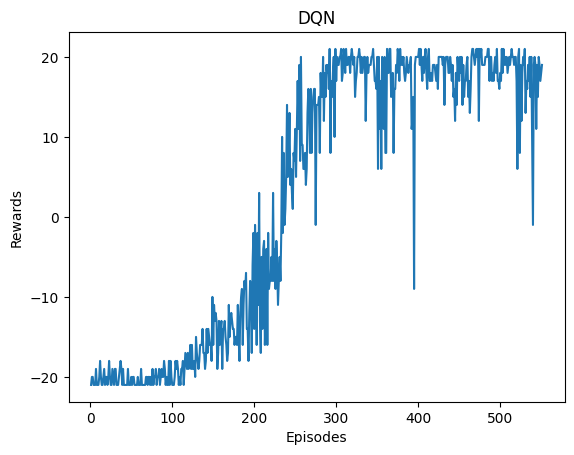

In [17]:
if __name__ == '__main__':
    game = 'Pong'
    env_name = 'PongNoFrameskip-v4'
    env = gym.make(env_name)
    env = AtariPreprocessing(env,
                      grayscale_obs=True,
                      scale_obs=False,
                      terminal_on_life_loss=True)
    env = FrameStack(env, num_stack=4)
    action_space = env.action_space
    agent = AgentDQN(env)
    agent.train()

In [18]:
env.close()
display = Display(visible=0, size=(1400, 900))
display.start()
new_env = gym.make(env_name)
new_env = AtariPreprocessing(new_env,
            grayscale_obs=True,
            scale_obs=True,
            terminal_on_life_loss=False)
new_env = wrap_env(FrameStack(new_env, num_stack=4))
state = np.array(new_env.reset(seed=30))
state = torch.from_numpy(state).unsqueeze(0)
state = state.cuda() if use_cuda else state
done = False
avg_reward = 0
i = 0
while(not done):
    new_env.render()
    action = agent.test_actions[i]
    i = i+1
    new_state, reward, done, info = new_env.step(action)
    new_state = np.array(new_state)
    new_state = torch.from_numpy(new_state).unsqueeze(0)
    new_state = new_state.cuda() if use_cuda else new_state
    state = new_state
    avg_reward += reward
print(f'Total reward in this episode {avg_reward}')
new_env.close()
show_video()

Total reward in this episode 20.0
